# Evaluation

This notebook includes various evaluation metrics of the trained met-ml model. 

In [78]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.distributed import Client
import seaborn as sns

from sklearn.metrics import explained_variance_score
import tensorflow as tf
from tensorflow.keras.models import load_model

from joblib import load, dump

from fluxnet_etl import load_fluxnet, make_lookback

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# load fitted transformers and model
y_trans = load('./etl_data/y_trans.joblib')
x_trans = load('./etl_data/x_trans.joblib')
model = load_model('./model.h5')

In [81]:
reload = False
if reload:
    client = Client(n_workers=25)
    x_data_computed, y_data_computed, meta = load_fluxnet(compute=True)
    dump(x_data_computed, 'x_data_computed.joblib')
    dump(y_data_computed, 'y_data_computed.joblib')
    dump(meta, 'meta.joblib')
else:
    x_data_computed = load('x_data_computed.joblib')
    y_data_computed = load('y_data_computed.joblib')
    meta = load('meta.joblib')

In [82]:
obs_data = {name: df for name, df in zip(meta.keys(), y_data_computed)}

In [7]:
eval_data = {}
for name, xdf in zip(meta.keys(), x_data_computed):
    x = make_lookback(x_trans.transform(xdf), xdf.columns)
    with tf.device('/GPU:0'):
        out = y_trans.inverse_transform(model.predict(x.values))
    eval_data[name] = pd.DataFrame(
        {'shortwave': out.squeeze()}, index=xdf.index[90:])

In [8]:
bench_data = {}
var_list = ['time', 'shortwave']
for name in meta.keys():
    df = pd.read_csv(f'./metsim_data/metsim_{name}_DD.csv',
                     parse_dates=True, index_col='time', usecols=var_list)
    bench_data[name] = df

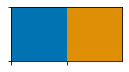

In [25]:
colors = sns.color_palette('colorblind', n_colors=2)
sns.palplot(colors)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:42728 remote=tcp://127.0.0.1:37393>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:42730 remote=tcp://127.0.0.1:37393>


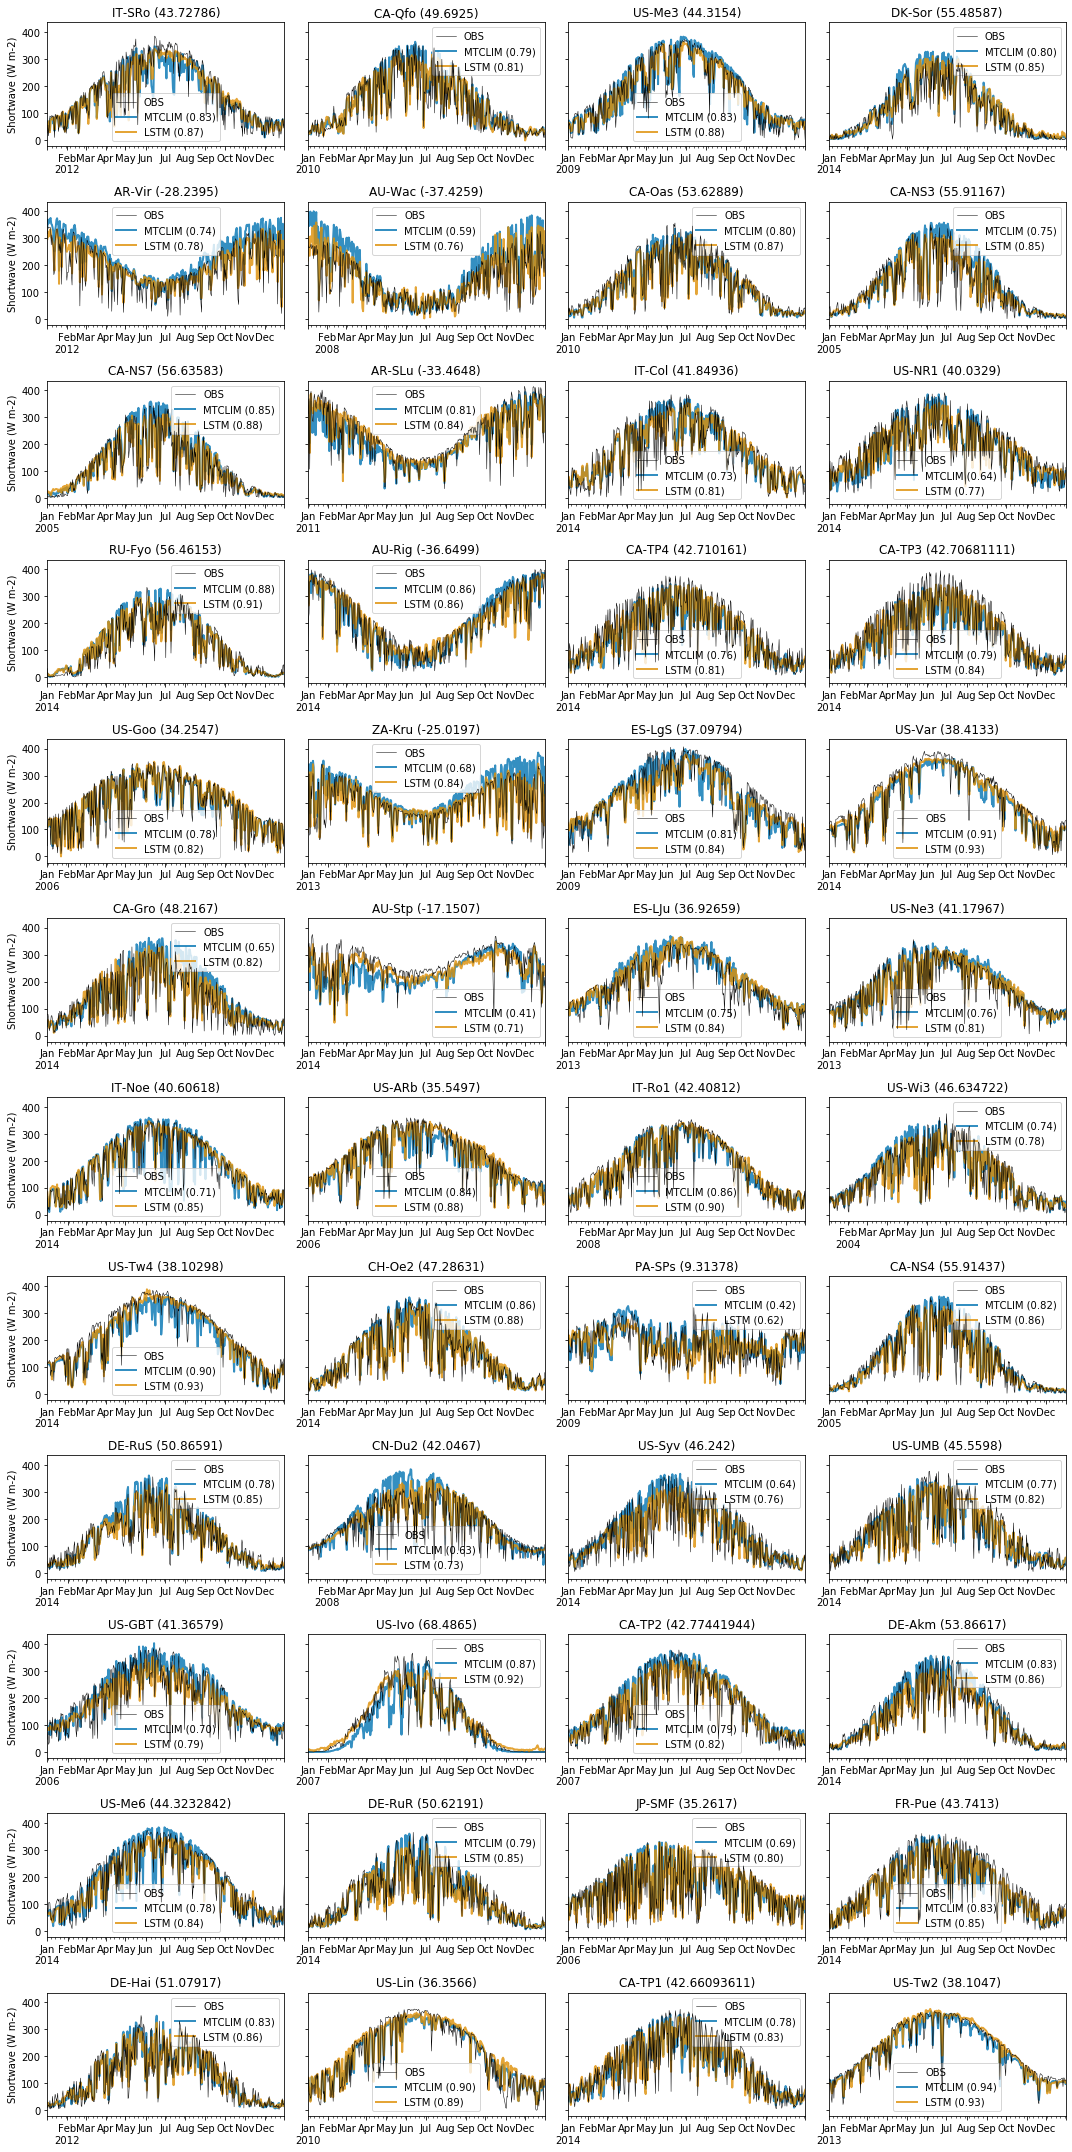

In [43]:
last_n = -365*1
var = 'shortwave'

style = {'OBS': dict(c='k', lw=0.5, zorder=10),
         'MTCLIM': dict(c=colors[0], lw=2, alpha=0.8),
         'LSTM': dict(c=colors[1], lw=2, alpha=0.8)}

fig, axes = plt.subplots(12, 4, figsize=(15, 30), sharex=False, sharey=True)

for ax, (name, site_meta) in zip(axes.flat, meta.items()):
    obs_data[name]['SW_IN_F'].iloc[last_n:].plot(label='OBS', ax=ax, **style['OBS'])
    for kind, df in [('MTCLIM', bench_data[name]), ('LSTM', eval_data[name])]:
        skill = explained_variance_score(obs_data[name]['SW_IN_F'].iloc[last_n:].values,
                                         df[var].iloc[last_n:].values)
        df.iloc[last_n:][var].plot(ax=ax, label=f'{kind} ({skill:0.2f})', **style[kind])
    ax.legend()
    ax.set_xlabel('')
    lat = site_meta['lat']
    ax.set_title(f'{name} ({lat})')
    
for ax in axes[:, 0]:
    ax.set_ylabel('Shortwave (W m-2)')
    
fig.tight_layout()
fig.savefig('results_daily.png', dpi=300)
plt.show()
plt.close('all')
    
    

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:42790 remote=tcp://127.0.0.1:37393>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:42794 remote=tcp://127.0.0.1:37393>


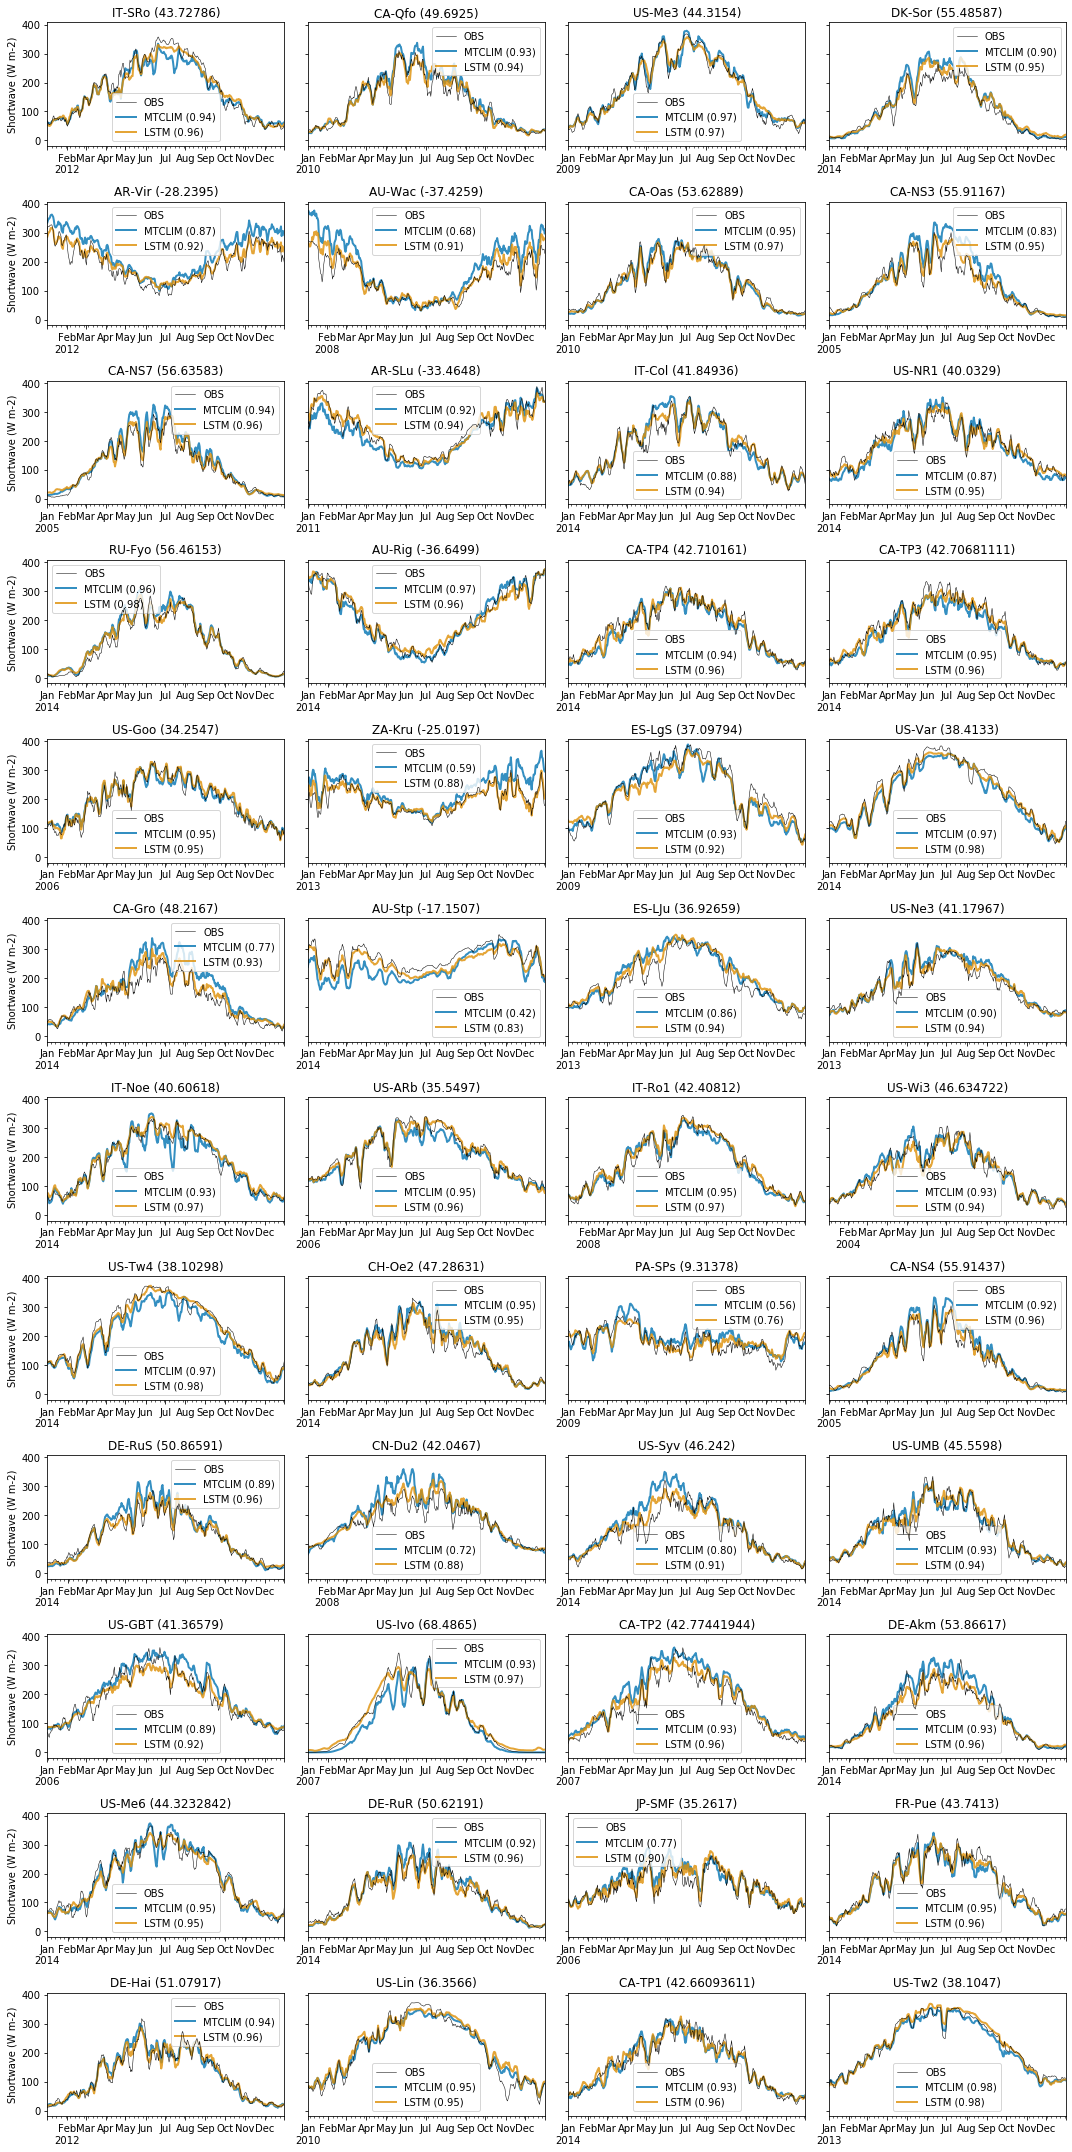

In [44]:
last_n = -365*1
var = 'shortwave'

style = {'OBS': dict(c='k', lw=0.5, zorder=10),
         'MTCLIM': dict(c=colors[0], lw=2, alpha=0.8),
         'LSTM': dict(c=colors[1], lw=2, alpha=0.8)}

fig, axes = plt.subplots(12, 4, figsize=(15, 30), sharex=False, sharey=True)

for ax, (name, site_meta) in zip(axes.flat, meta.items()):
    obs_data[name]['SW_IN_F'].rolling(7).mean().iloc[last_n:].plot(label='OBS', ax=ax, **style['OBS'])
    for kind, df in [('MTCLIM', bench_data[name]), ('LSTM', eval_data[name])]:
        skill = explained_variance_score(obs_data[name]['SW_IN_F'].rolling(7).mean().iloc[last_n:].values,
                                         df[var].rolling(7).mean().iloc[last_n:].values)
        df.rolling(7).mean().iloc[last_n:][var].plot(ax=ax, label=f'{kind} ({skill:0.2f})', **style[kind])
    ax.legend()
    ax.set_xlabel('')
    lat = site_meta['lat']
    ax.set_title(f'{name} ({lat})')
    
for ax in axes[:, 0]:
    ax.set_ylabel('Shortwave (W m-2)')
    

fig.tight_layout()
fig.savefig('results_daily_7drolling.png', dpi=300)
plt.show()
plt.close('all')
    
    

In [59]:
val_perf = []
train_perf = []
metsim_perf = []
for name in meta.keys():
    train_perf.append(explained_variance_score(obs_data[name]['SW_IN_F'].iloc[90:last_n], eval_data[name].iloc[:last_n][var]))
    val_perf.append(explained_variance_score(obs_data[name]['SW_IN_F'].iloc[last_n:], eval_data[name].iloc[last_n:][var]))
    metsim_perf.append(explained_variance_score(obs_data[name]['SW_IN_F'].iloc[last_n:], bench_data[name].iloc[last_n:][var]))

perf = pd.DataFrame({'val': val_perf, 'train': train_perf, 'metsim': metsim_perf}, index=list(meta.keys()))

In [74]:
worst = perf.sort_values('val')[:12]
worst

,val,train,metsim
PA-SPn,-0.526571,0.662985,0.110378
SD-Dem,0.237069,0.602607,-0.231074
AU-Fog,0.312464,0.505769,0.246492
ZM-Mon,0.377907,0.726009,-0.404226
GH-Ank,0.458869,0.631292,0.388965
US-KS2,0.539220,0.702030,0.447564
CN-Cha,0.567646,0.670739,0.490620
CN-Dan,0.613707,0.715195,0.414440
PA-SPs,0.617950,0.669658,0.421493
AU-Ade,0.656338,0.674743,0.391611


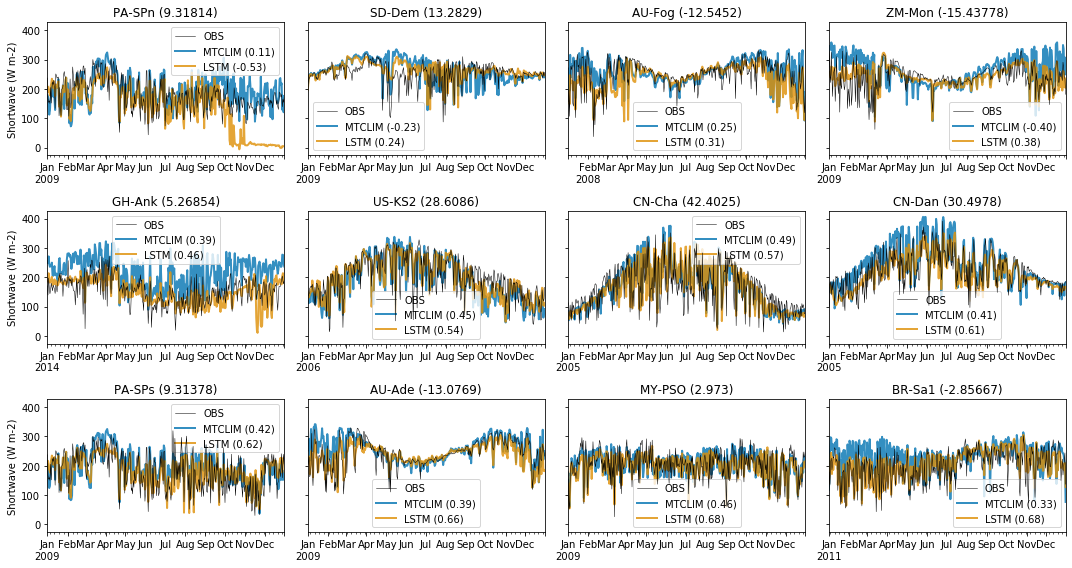

In [77]:
last_n = -365*1
var = 'shortwave'
rolling = 1

style = {'OBS': dict(c='k', lw=0.5, zorder=10),
         'MTCLIM': dict(c=colors[0], lw=2, alpha=0.8),
         'LSTM': dict(c=colors[1], lw=2, alpha=0.8)}

fig, axes = plt.subplots(3, 4, figsize=(15, 8), sharex=False, sharey=True)

worst_meta = {name: meta[name] for name in worst.index}

for ax, (name, site_meta) in zip(axes.flat, worst_meta.items()):
    obs_data[name]['SW_IN_F'].rolling(1).mean().iloc[last_n:].plot(label='OBS', ax=ax, **style['OBS'])
    for kind, df in [('MTCLIM', bench_data[name]), ('LSTM', eval_data[name])]:
        skill = explained_variance_score(obs_data[name]['SW_IN_F'].rolling(rolling).mean().iloc[last_n:].values,
                                         df[var].rolling(rolling).mean().iloc[last_n:].values)
        df.rolling(rolling).mean().iloc[last_n:][var].plot(ax=ax, label=f'{kind} ({skill:0.2f})', **style[kind])
    ax.legend()
    ax.set_xlabel('')
    lat = site_meta['lat']
    ax.set_title(f'{name} ({lat})')
    
for ax in axes[:, 0]:
    ax.set_ylabel('Shortwave (W m-2)')
    

fig.tight_layout()
# fig.savefig('results_daily_7drolling.png', dpi=300)
plt.show()
plt.close('all')